In [ ]:
# !pip install optuna

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import gc, warnings, random, time, os

from pathlib import Path

from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import get_cosine_schedule_with_warmup

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import seaborn as sns

import gc
gc.enable()

import optuna

### Folders and Dataframes

In [2]:
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()

In [3]:
train_df = pd.read_csv(DATA_PATH/'train-orig.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

In [4]:
def remove_unnecessary(df):
    df.drop(df[df['target'] == 0].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
remove_unnecessary(train_df)

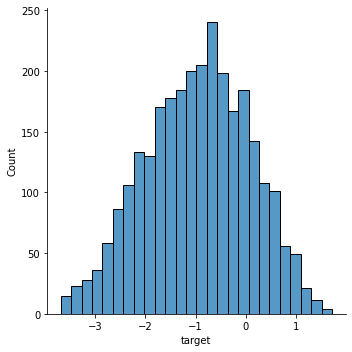

In [5]:
sns.displot(train_df['target'])

### Config and Seeding

In [6]:
class Config(): 
    NUM_FOLDS = 6
    NUM_EPOCHS = 4
    BATCH_SIZE = 16
    MAX_LEN = 248
    EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
    ROBERTA_PATH = '/home/commonlit/models/deberta-large-lm/best_lm'
    TOKENIZER_PATH = '/home/commonlit/models/deberta-large-lm/best_lm'
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 1000
    NUM_WORKERS = 2
    MODEL_FOLDER = MODELS_PATH
    model_name = 'deberta-large-uniform'
    svm_kernels = ['rbf']
    svm_c = 5

cfg = Config()

In [7]:
if not cfg.MODEL_FOLDER.exists():
    os.mkdir(cfg.MODEL_FOLDER)

In [8]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

### Dataset

In [9]:
def add_bins(train_df, num_bins):
    train_df.loc[:, 'bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)
    return num_bins

In [10]:
add_bins(train_df, cfg.NUM_FOLDS)

6

In [11]:
train_df['bins'].value_counts()

3    886
2    784
4    494
1    441
0    122
5    106
Name: bins, dtype: int64

In [12]:
train_df.groupby(['bins'])['target'].agg(['count', 'mean'])

,count,mean
bins,,
0,122,-3.125765
1,441,-2.270279
2,784,-1.412150
3,886,-0.548095
4,494,0.289716
5,106,1.070237


In [13]:
tokenizer = AutoTokenizer.from_pretrained(cfg.TOKENIZER_PATH)

In [14]:
class CommonLitDataset(Dataset):
    def __init__(self, df, tokenizer, inference_only=False):
        super().__init__()
        self.df, self.inference_only = df, inference_only
        self.text = df['excerpt'].tolist()
        self.bins = df['bins']
        if not inference_only:
            self.target = torch.tensor(df['target'].to_numpy(), dtype = torch.float32)
        
        self.encoded = tokenizer.batch_encode_plus(
            self.text,
            padding = 'max_length',
            max_length = cfg.MAX_LEN,
            truncation = True,
            return_attention_mask=True
        )
        
    def __getitem__(self, index):        
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        
        if self.inference_only:
            return {'input_ids': input_ids, 'attention_mask': attention_mask}
        else:
            target = self.target[index]
            return {'input_ids': input_ids, 'attention_mask': attention_mask, 'target': target}
    
    def __len__(self):
        return len(self.df)
    
    def __repr__(self):
        return f'{len(self.df)} records'

In [15]:
sample_ds = CommonLitDataset(train_df, tokenizer)

In [16]:
sample_ds

2833 records

### Model

In [17]:
class AttentionHead(nn.Module):
    
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        
        self.hidden_layer = nn.Linear(in_features, hidden_dim)
        self.final_layer = nn.Linear(hidden_dim, num_targets)
        self.out_features = hidden_dim
        
    def forward(self, features):
        att = torch.tanh(self.hidden_layer(features))
        score = self.final_layer(att)
        attention_weights = torch.softmax(score, dim=1)
        return attention_weights

In [18]:
class CommonLitModel(nn.Module):
    def __init__(self):
        super(CommonLitModel, self).__init__()
        config = AutoConfig.from_pretrained(cfg.ROBERTA_PATH)
        config.update({
            "output_hidden_states": True,
            "hidden_dropout_prob": 0.0,
            "layer_norm_eps": 1e-7
        })
        self.transformer_model = AutoModel.from_pretrained(cfg.ROBERTA_PATH, config=config)
        self.attention = AttentionHead(config.hidden_size, 512, 1)
        self.regressor = nn.Linear(config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask):
        last_layer_hidden_states = self.transformer_model(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']
        weights = self.attention(last_layer_hidden_states)
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1) 
        return self.regressor(context_vector), context_vector

In [19]:
sample_model = CommonLitModel()

Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
import re

for i, (name, param) in enumerate(sample_model.named_parameters()):
    if(name.find('layer') > -1):
        layer_name = re.sub(r'.+(layer\.\d+).+', r'\1', name)

In [21]:
for i, (name, param) in enumerate(sample_model.named_parameters()):
    print(i, name, param.size())

0 transformer_model.embeddings.word_embeddings.weight torch.Size([50265, 1024])
1 transformer_model.embeddings.LayerNorm.weight torch.Size([1024])
2 transformer_model.embeddings.LayerNorm.bias torch.Size([1024])
3 transformer_model.encoder.layer.0.attention.self.q_bias torch.Size([1024])
4 transformer_model.encoder.layer.0.attention.self.v_bias torch.Size([1024])
5 transformer_model.encoder.layer.0.attention.self.in_proj.weight torch.Size([3072, 1024])
6 transformer_model.encoder.layer.0.attention.self.pos_proj.weight torch.Size([1024, 1024])
7 transformer_model.encoder.layer.0.attention.self.pos_q_proj.weight torch.Size([1024, 1024])
8 transformer_model.encoder.layer.0.attention.self.pos_q_proj.bias torch.Size([1024])
9 transformer_model.encoder.layer.0.attention.output.dense.weight torch.Size([1024, 1024])
10 transformer_model.encoder.layer.0.attention.output.dense.bias torch.Size([1024])
11 transformer_model.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([1024])
12 tra

In [22]:
sample_input_ids = torch.randint(0, 1000, [8, 248])
sample_attention_mask = torch.randint(0, 1000, [8, 248])

In [23]:
sample_model(sample_input_ids, sample_attention_mask)[1].shape

torch.Size([8, 1024])

In [24]:
torch.sum(torch.randn([8, 496, 768]), axis=1)

tensor([[ 18.5696,  22.2834, -19.6048,  ...,  14.5450,  -6.4439,  -7.6526],
        [  9.9711, -18.0911,  37.9014,  ...,  33.6703,   4.7925,  -7.2030],
        [ 13.7893,   8.0198,  -7.7403,  ...,  23.0422,  -1.0622,   3.6124],
        ...,
        [-14.4509,   7.3179,  25.4754,  ..., -19.0306,  22.1846,  -9.0804],
        [  2.6181,  28.3989,  15.1862,  ...,  15.3681,   3.9010,  16.4605],
        [  4.4850, -33.8052,  31.8944,  ..., -18.6333,  34.9414,  -4.1955]])

### Evaluation and Prediction

In [25]:
def eval_mse(model, data_loader):
    model.eval()
    mse_sum = 0
    mse_loss = nn.MSELoss(reduction='sum')
    
    with torch.no_grad():
        for batch_num, record in enumerate(data_loader):
            input_ids, attention_mask, target = record['input_ids'].to(cfg.DEVICE), record['attention_mask'].to(cfg.DEVICE), record['target'].to(cfg.DEVICE)
            pred, _ = model(input_ids, attention_mask)
            mse_sum += mse_loss(pred.flatten().cpu(), target.cpu())
            
    return mse_sum / len(data_loader.dataset)

In [26]:
def predict(model, data_loader):
    model.eval()
    result = []
    
    with torch.no_grad():
        for batch_num, record in tqdm(enumerate(data_loader), total=len(data_loader)):
            input_ids, attention_mask = record['input_ids'].to(cfg.DEVICE), record['attention_mask'].to(cfg.DEVICE)
            pred, _ = model(input_ids, attention_mask)
            result.extend(pred.flatten().to("cpu").tolist())
            
    return np.array(result)

In [27]:
sample_dl = DataLoader(sample_ds, shuffle=False, batch_size=16, num_workers=1)

### Optimizer and Sampler

In [28]:
def create_optimizer(model, base_lr=5e-5, last_lr=None):
    named_parameters = list(model.named_parameters())
    attention_param_start = 388
    regressor_param_start = 392
    roberta_parameters = named_parameters[:attention_param_start]
    attention_parameters = named_parameters[attention_param_start:regressor_param_start]
    regressor_parameters = named_parameters[regressor_param_start:]
    
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]
    
    parameters = []
    if last_lr is not None:
        parameters.append({"params": attention_group, "lr": last_lr})
        parameters.append({"params": regressor_group, "lr": last_lr})
    else:
        parameters.append({"params": attention_group})
        parameters.append({"params": regressor_group})
        
    # Change on different models
    layer_low_threshold = 195
    layer_middle_threshold = 323
    
    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if 'bias' in name else 0.01
        
        lr = base_lr / 2.5 # 2e-05
        if layer_num >= layer_middle_threshold:
            lr = base_lr / 0.5 # 1e-4
        elif layer_num >= layer_low_threshold:        
            lr = base_lr    
            
        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})
        
    return AdamW(parameters)

In [29]:
sample_optimizer = create_optimizer(sample_model)

In [30]:
from torch.utils.data import Sampler,SequentialSampler,RandomSampler,SubsetRandomSampler
from collections import Counter

class WeightedSampler(Sampler):
    
    def __init__(self, dataset):
        
        len_dataset = len(dataset)
        self.indices = list(range(len_dataset))
        self.num_samples = len_dataset
        self.label_to_count = dict(Counter(dataset.bins))
        weights = [1/self.label_to_count[i] for i in dataset.bins]
        
        self.weights = torch.tensor(weights,dtype=torch.double)
        
    def __iter__(self):
        count = 0
        index = [self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True)]
        while count < self.num_samples:
            yield index[count]
            count += 1
    
    def __len__(self):
        return self.num_samples

In [31]:
indices = list(range(len(sample_ds)))
num_samples = len(sample_ds)
label_to_count = dict(Counter(sample_ds.bins))

In [32]:
label_to_count

{3: 886, 2: 784, 4: 494, 0: 122, 1: 441, 5: 106}

In [33]:
weights = [1/label_to_count[i] for i in sample_ds.bins]
sum(weights)

5.999999999999999

<AxesSubplot:ylabel='Density'>

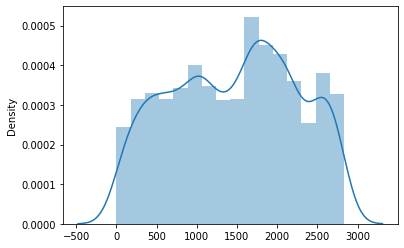

In [34]:
sns.distplot(torch.multinomial(torch.tensor(weights), num_samples, replacement=True))

In [35]:
train_df_copy = train_df.copy()

In [36]:
train_df_copy.sort_values(['target']).reset_index(inplace=True)

In [37]:
np.random.choice(np.arange(len(train_df_copy)), len(train_df_copy))

array([2415,  100,  252, ..., 2623,  579, 2100])

### Training

In [38]:
def choose_eval_period(val_rmse):
    for rmse, period in cfg.EVAL_SCHEDULE:
        if val_rmse >= rmse:
            return period

In [39]:
def serialize_best(best_val_rmse, best_epoch, val_rmse, epoch, model, model_path):
    if not best_val_rmse or val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_epoch = epoch
        if not model_path.parent.exists():
            os.makedirs(model_path.parent)
        
        torch.save(model.state_dict(), model_path)
        print(f"New best_val_rmse: {best_val_rmse:0.4}")
    else:       
        print(f"Still best_val_rmse: {best_val_rmse:0.4}",
              f"(from epoch {best_epoch})")
    return best_epoch, best_val_rmse

In [40]:
class Trainer():
    def __init__(self, scaler, model, model_path, train_loader, val_loader, optimizer, scheduler=None, num_epochs=cfg.NUM_EPOCHS):
        self.scaler, self.model, self.model_path, self.train_loader, self.val_loader, self.optimizer, self.scheduler, self.num_epochs = (
            scaler, model, model_path, train_loader, val_loader, optimizer, scheduler, num_epochs
        )
            
    def train(self):
        self.model.train()
        
        mse_loss = nn.MSELoss(reduction='mean')
        
        best_val_rmse = None
        best_epoch = 0
        step = 0
        last_eval_step = 0
        eval_period = cfg.EVAL_SCHEDULE[0][1]    

        start = time.time()
        
        tbar = tqdm(range(self.num_epochs), total=self.num_epochs)
        for epoch in tbar:
            tbar.set_description(f'Epoch: {epoch}')
            val_rmse = None
            for batch_num, record in enumerate(self.train_loader):
                input_ids, attention_mask, target = record['input_ids'].to(cfg.DEVICE), record['attention_mask'].to(cfg.DEVICE), record['target'].to(cfg.DEVICE)
                
                self.optimizer.zero_grad()
                
                # Casts operations to mixed precision
                with torch.cuda.amp.autocast():
                    pred, _ = self.model(input_ids, attention_mask)
                    mse = mse_loss(pred.flatten(), target)
                    
                self.scaler.scale(mse).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                
                if self.scheduler:
                    self.scheduler.step()
                    
                if step >= last_eval_step + eval_period:
                    elapsed_seconds = time.time() - start
                    num_steps = step - last_eval_step
                    print(f"\n{num_steps} steps took {elapsed_seconds:0.3} seconds")
                    last_eval_step = step
                    
                    val_rmse = np.sqrt(eval_mse(self.model, self.val_loader))
                    print(f"Epoch: {epoch} batch_num: {batch_num}", f"val_rmse: {val_rmse:0.4} ", end='')
                    
                    eval_period = choose_eval_period(val_rmse)
                    best_epoch, best_val_rmse = serialize_best(best_val_rmse, best_epoch, val_rmse, epoch, self.model, self.model_path)
                    start = time.time()
                # Finish early on condition
                if epoch > 0 and best_val_rmse > 0.6:
                    return best_val_rmse
                
                step += 1
        return best_val_rmse

In [41]:
kfold = KFold(n_splits=cfg.NUM_FOLDS, random_state=cfg.SEED, shuffle=True)
splits = list(kfold.split(train_df))

### Main Training

In [42]:
def train_fold(base_lr, last_lr, fold = 0, scheduler_func = get_cosine_schedule_with_warmup):
    
    print(f'##### Using fold {fold}')
    
    model_path = cfg.MODEL_FOLDER/f"{cfg.model_name.replace('/', '_')}_{fold + 1}/model_{fold + 1}.pth"
    
    set_random_seed(cfg.SEED + fold)
    
    tokenizer = AutoTokenizer.from_pretrained(cfg.TOKENIZER_PATH)
    
    train_indices, val_indices = splits[fold]
    train_dataset = CommonLitDataset(train_df.loc[train_indices], tokenizer)    
    val_dataset = CommonLitDataset(train_df.loc[val_indices], tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE,
                              drop_last=False, shuffle=True, num_workers=cfg.NUM_WORKERS)    
    val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE,
                            drop_last=False, shuffle=False, num_workers=cfg.NUM_WORKERS)
    
    set_random_seed(cfg.SEED + fold)
    
    model = CommonLitModel().to(cfg.DEVICE)
    
    optimizer = create_optimizer(model, base_lr=base_lr, last_lr=last_lr)
    
    scheduler = scheduler_func(optimizer,
                                                num_training_steps=cfg.NUM_EPOCHS * len(train_loader), 
                                                num_warmup_steps=50)
    
    scaler = torch.cuda.amp.GradScaler()
    
    trainer = Trainer(scaler, model, model_path, train_loader, val_loader, optimizer, scheduler = scheduler)
    rmse_val = trainer.train()
    tokenizer.save_pretrained(str(model_path.parent))
    
    return rmse_val

In [43]:
# Best results
# fold 0: {'base_lr': 4.214048623230046e-05, 'last_lr': 0.00098671139242345}. Best is trial 0 with value: 0.46920305490493774.
# fold 1: {'base_lr': 3.4594372607385946e-05, 'last_lr': 0.0005479134338105077}. Best is trial 0 with value: 0.447492390871048
# fold 2: {'base_lr': 1.777623134028703e-05, 'last_lr': 0.004132549020616918}. Best is trial 0 with value: 0.46756473183631897
# fold 3: {'base_lr': 3.933402254716856e-05, 'last_lr': 0.0018473297738188957}. Best is trial 11 with value: 0.4719877541065216
# fold 4: {'base_lr': 1.845975941382356e-05, 'last_lr': 0.0006309278277674714}. Best is trial 15 with value: 0.46920618414878845
# fold 5: {'base_lr': 4.430444436442592e-05, 'last_lr': 0.000289231685619846}. Best is trial 6 with value: 0.4629150927066803

In [45]:
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

lr_list = [
    {'base_lr': 3.9152303052330085e-05, 'last_lr': 0.00045881520547034934, 'schedule_func': get_cosine_schedule_with_warmup}, # Best is trial 15 with value: 0.4751589596271515,
    {'base_lr': 3.4594372607385946e-05, 'last_lr': 0.0005479134338105077},
    {'base_lr': 1.777623134028703e-05, 'last_lr': 0.004132549020616918},
    {'base_lr': 3.933402254716856e-05, 'last_lr': 0.0018473297738188957},
    {'base_lr': 4.395940545935742e-05, 'last_lr': 0.0008065830888769318, 'schedule_func': get_cosine_schedule_with_warmup}, # 0.4748414158821106
    {'base_lr': 4.430444436442592e-05, 'last_lr': 0.000289231685619846}
]

In [46]:
%%time

rmse_values = []
for i in range(len(list(splits))):
    fold = i
    lrs = lr_list[fold]
    rmse_val = train_fold(lrs['base_lr'], lrs['last_lr'], fold=fold, scheduler_func = lrs['schedule_func'] if 'schedule_func' in lrs else get_cosine_schedule_with_warmup)
    print(f'Final RMSE: {rmse_val}')
    rmse_values.append(rmse_val)

##### Using fold 0


Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



16 steps took 9.69 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.8327 New best_val_rmse: 0.8327

16 steps took 6.69 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.8693 Still best_val_rmse: 0.8327 (from epoch 0)

16 steps took 6.74 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.6203 New best_val_rmse: 0.6203

16 steps took 6.77 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.6265 Still best_val_rmse: 0.6203 (from epoch 0)

16 steps took 6.75 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.6645 Still best_val_rmse: 0.6203 (from epoch 0)

16 steps took 6.79 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.7774 Still best_val_rmse: 0.6203 (from epoch 0)

16 steps took 6.77 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.6186 New best_val_rmse: 0.6186

16 steps took 6.8 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.652 Still best_val_rmse: 0.6186 (from epoch 0)

16 steps took 6.78 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.5408 New best_val_rmse: 0.5408

16 steps took 7.59 seconds
Epoch: 1 batch_num: 12 val_rmse: 0.5086 

Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



16 steps took 8.32 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.7932 New best_val_rmse: 0.7932

16 steps took 6.81 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.5904 New best_val_rmse: 0.5904

16 steps took 6.79 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.8069 Still best_val_rmse: 0.5904 (from epoch 0)

16 steps took 6.82 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.5796 New best_val_rmse: 0.5796

16 steps took 6.81 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.5946 Still best_val_rmse: 0.5796 (from epoch 0)

16 steps took 6.81 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.5603 New best_val_rmse: 0.5603

16 steps took 6.81 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.6503 Still best_val_rmse: 0.5603 (from epoch 0)

16 steps took 6.82 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.5377 New best_val_rmse: 0.5377

16 steps took 6.8 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.506 New best_val_rmse: 0.506

16 steps took 7.72 seconds
Epoch: 1 batch_num: 12 val_rmse: 0.5738 Still best_val_rmse: 0.506 (from ep

Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



16 steps took 8.37 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.8068 New best_val_rmse: 0.8068

16 steps took 6.86 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.8205 Still best_val_rmse: 0.8068 (from epoch 0)

16 steps took 6.81 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.983 Still best_val_rmse: 0.8068 (from epoch 0)

16 steps took 6.81 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.6531 New best_val_rmse: 0.6531

16 steps took 6.82 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.6392 New best_val_rmse: 0.6392

16 steps took 6.83 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.693 Still best_val_rmse: 0.6392 (from epoch 0)

16 steps took 6.82 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.6499 Still best_val_rmse: 0.6392 (from epoch 0)

16 steps took 6.84 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.5738 New best_val_rmse: 0.5738

16 steps took 6.86 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.7639 Still best_val_rmse: 0.5738 (from epoch 0)

16 steps took 7.62 seconds
Epoch: 1 batch_num: 12 val_rmse: 0.6264 

Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



16 steps took 8.68 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.8126 New best_val_rmse: 0.8126

16 steps took 6.8 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.8459 Still best_val_rmse: 0.8126 (from epoch 0)

16 steps took 6.83 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.6837 New best_val_rmse: 0.6837

16 steps took 6.84 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.618 New best_val_rmse: 0.618

16 steps took 6.85 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.6432 Still best_val_rmse: 0.618 (from epoch 0)

16 steps took 6.83 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.5784 New best_val_rmse: 0.5784

16 steps took 6.8 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.5316 New best_val_rmse: 0.5316

16 steps took 6.84 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.8139 Still best_val_rmse: 0.5316 (from epoch 0)

16 steps took 6.84 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.5504 Still best_val_rmse: 0.5316 (from epoch 0)

16 steps took 7.66 seconds
Epoch: 1 batch_num: 12 val_rmse: 0.5289 New best_val_rmse: 0

Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



16 steps took 8.27 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.94 New best_val_rmse: 0.94

16 steps took 6.75 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.6271 New best_val_rmse: 0.6271

16 steps took 6.83 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.7002 Still best_val_rmse: 0.6271 (from epoch 0)

16 steps took 6.8 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.6333 Still best_val_rmse: 0.6271 (from epoch 0)

16 steps took 6.8 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.8325 Still best_val_rmse: 0.6271 (from epoch 0)

16 steps took 6.84 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.6371 Still best_val_rmse: 0.6271 (from epoch 0)

16 steps took 6.83 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.5816 New best_val_rmse: 0.5816

16 steps took 6.82 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.7343 Still best_val_rmse: 0.5816 (from epoch 0)

16 steps took 6.82 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.5597 New best_val_rmse: 0.5597

16 steps took 7.62 seconds
Epoch: 1 batch_num: 12 val_rmse: 0.6473 Stil

Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



16 steps took 8.34 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.8675 New best_val_rmse: 0.8675

16 steps took 6.81 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.6821 New best_val_rmse: 0.6821

16 steps took 6.81 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.741 Still best_val_rmse: 0.6821 (from epoch 0)

16 steps took 6.83 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.5872 New best_val_rmse: 0.5872

16 steps took 6.81 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.6354 Still best_val_rmse: 0.5872 (from epoch 0)

16 steps took 6.83 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.5486 New best_val_rmse: 0.5486

16 steps took 6.81 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.6269 Still best_val_rmse: 0.5486 (from epoch 0)

16 steps took 6.81 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.5735 Still best_val_rmse: 0.5486 (from epoch 0)

16 steps took 6.83 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.5076 New best_val_rmse: 0.5076

16 steps took 7.63 seconds
Epoch: 1 batch_num: 12 val_rmse: 0.4936 New best_val_rms

In [47]:
f'mean RMSE values: {np.mean(np.array(rmse_values))}'

'mean RMSE values: 0.468708872795105'

### Verify the model

In [48]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [49]:
cfg.model_offset = 0
cfg.model_limit = 6
cfg.n_folds = 5
cfg.svm_kernels = ['rbf']
cfg.svm_c = 5

In [50]:
num_bins = int(np.ceil(np.log2(len(train_df))))
train_df['bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)
bins = train_df['bins'].values

In [51]:
%%time

inference_models = []
for i in range(1, cfg.NUM_FOLDS + 1):
    print(f'Model {i}')
    inference_model = CommonLitModel()
    inference_model = inference_model.cuda()
    inference_model.load_state_dict(torch.load(str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}_{i}/model_{i}.pth")))
    inference_model.eval();
    inference_models.append(inference_model)

Model 1


Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 2


Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 3


Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 4


Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 5


Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 6


Some weights of the model checkpoint at /home/commonlit/models/deberta-large-lm/best_lm were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 25.9 s, sys: 7.64 s, total: 33.5 s
Wall time: 29.8 s


In [52]:
from transformers import RobertaTokenizer

tokenizers = []
for i in range(1, cfg.NUM_FOLDS):
    tokenizer = RobertaTokenizer.from_pretrained(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}_{i}")
    tokenizers.append(tokenizer)

In [53]:
def get_cls_embeddings(dl, transformer_model):
    cls_embeddings = []
    with torch.no_grad():
        for input_features in tqdm(dl, total=len(dl)):
            output, context_vector = transformer_model(input_features['input_ids'].cuda(), input_features['attention_mask'].cuda())
#             cls_embeddings.extend(output['last_hidden_state'][:,0,:].detach().cpu().numpy())
            embedding_out = context_vector.detach().cpu().numpy()
            cls_embeddings.extend(embedding_out)
    return np.array(cls_embeddings)

In [54]:
def rmse_score(X, y):
    return np.sqrt(mean_squared_error(X, y))

In [55]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, test_id, tokenizer, max_len=128):
        self.excerpt = text
        self.test_id = test_id
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return {'input_ids': convert_to_list(encode['input_ids']),
                'attention_mask': convert_to_list(encode['attention_mask']),
                'id': self.test_id[idx]}
    
    def __len__(self):
        return len(self.excerpt)

In [56]:
def create_dl(df, tokenizer):
    text = df['excerpt'].values
    ids = df['id'].values
    ds = CommonLitDataset(text, ids, tokenizer, max_len=cfg.MAX_LEN)
    return DataLoader(ds, 
                      batch_size = cfg.BATCH_SIZE,
                      shuffle=False,
                      num_workers = 1,
                      pin_memory=True,
                      drop_last=False
                     )

In [57]:
train_df = pd.read_csv(DATA_PATH/'train-orig.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
remove_unnecessary(train_df)

In [58]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [59]:
%%time

train_target = train_df['normalized_target'].values

def calc_mean(scores):
    return np.mean(np.array(scores), axis=0)

final_scores = []
final_rmse = []
kernel_rmse_score_mean = []
final_kernel_predictions_means = []
for j, (inference_model, tokenizer) in enumerate(zip(inference_models, tokenizers)):
    print('Model', j)
    test_dl = create_dl(test_df, tokenizer)
    train_dl = create_dl(train_df, tokenizer)
    transformer_model = inference_model
    transformer_model.cuda()
    X = get_cls_embeddings(train_dl, transformer_model)
    
    y = train_target
    X_test = get_cls_embeddings(test_dl, transformer_model)
    
    kfold = StratifiedKFold(n_splits=cfg.NUM_FOLDS)
    scores = []
    rmse_scores = []
    kernel_predictions_means = []
    for kernel in cfg.svm_kernels:
        print('Kernel', kernel)
        kernel_scores = []
        kernel_rmse_scores = []
        kernel_predictions = []
        for k, (train_idx, valid_idx) in enumerate(kfold.split(X, bins)):

            print('Fold', k, train_idx.shape, valid_idx.shape)
            model = SVR(C=cfg.svm_c, kernel=kernel, gamma='auto')

            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            model.fit(X_train, y_train)
            prediction = model.predict(X_valid)
            kernel_predictions.append(prediction)
            kernel_rmse_scores.append(rmse_score(prediction, y_valid))
            print('rmse_score', kernel_rmse_scores[k])
            kernel_scores.append(model.predict(X_test))
        kernel_predictions_means.append(np.array([np.mean(kp) for kp in kernel_predictions]).mean())
        scores.append(calc_mean(kernel_scores))
        kernel_rmse_score = calc_mean(kernel_rmse_scores)
        kernel_rmse_score_mean.append(kernel_rmse_score)
        rmse_scores.append(kernel_rmse_score)
    final_kernel_predictions_means.append(kernel_predictions_means)
    final_scores.append(calc_mean(scores))
    final_rmse.append(calc_mean(rmse_scores))
print('FINAL RMSE score', np.mean(np.array(final_rmse)))

Model 0



Kernel rbf
Fold 0 (2360,) (473,)
rmse_score 0.2686695418357563
Fold 1 (2361,) (472,)
rmse_score 0.24120747723363972
Fold 2 (2361,) (472,)
rmse_score 0.24626021060074163
Fold 3 (2361,) (472,)
rmse_score 0.2040639478259469
Fold 4 (2361,) (472,)
rmse_score 0.2457987052565849
Fold 5 (2361,) (472,)
rmse_score 0.2626301834086225
Model 1



Kernel rbf
Fold 0 (2360,) (473,)
rmse_score 0.3524799040604675
Fold 1 (2361,) (472,)
rmse_score 0.3573640490358266
Fold 2 (2361,) (472,)
rmse_score 0.3246639505761059
Fold 3 (2361,) (472,)
rmse_score 0.33647310612935655
Fold 4 (2361,) (472,)
rmse_score 0.32088533402434594
Fold 5 (2361,) (472,)
rmse_score 0.36134417042407063
Model 2



Kernel rbf
Fold 0 (2360,) (473,)
rmse_score 0.28791424523581755
Fold 1 (2361,) (472,)
rmse_score 0.27612195429140873
Fold 2 (2361,) (472,)
rmse_score 0.24907389913547862
Fold 3 (2361,) (472,)
rmse_score 0.27232139933035243
Fold 4 (2361,) (472,)
rmse_score 0.27536060716171495
Fold 5 (2361,) (472,)
rmse_score 0.29525954867913023
Model 3



Kernel rbf
Fold 0 (2360,) (473,)
rmse_score 0.2165313024044066
Fold 1 (2361,) (472,)
rmse_score 0.23576847372154897
Fold 2 (2361,) (472,)
rmse_score 0.23441848261283332
Fold 3 (2361,) (472,)
rmse_score 0.20192891174055294
Fold 4 (2361,) (472,)
rmse_score 0.22767141604435875
Fold 5 (2361,) (472,)
rmse_score 0.23527797089590427
Model 4



Kernel rbf
Fold 0 (2360,) (473,)
rmse_score 0.2600705124115583
Fold 1 (2361,) (472,)
rmse_score 0.23594197853422755
Fold 2 (2361,) (472,)
rmse_score 0.21447733451373757
Fold 3 (2361,) (472,)
rmse_score 0.21130841011438553
Fold 4 (2361,) (472,)
rmse_score 0.25186068632231773
Fold 5 (2361,) (472,)
rmse_score 0.2564435484111153
FINAL RMSE score 0.2653197087324105
CPU times: user 3min 48s, sys: 8.77 s, total: 3min 57s
Wall time: 3min 55s


In [60]:
final_kernel_predictions_means

[[0.0056726339400725015],
 [-0.005418542700957314],
 [0.004047111491866357],
 [0.0012284998837947556],
 [-0.0004779982235605211]]

In [61]:
# (train_df['target'] - cfg.train_target_mean) / cfg.train_target_std
final_scores_normalized = np.array(final_scores) * train_target_std + train_target_mean

In [62]:
kernel_rmse_score_mean_array = np.array(kernel_rmse_score_mean)
kernel_rmse_score_mean_sum = np.sum(kernel_rmse_score_mean_array)
prop_losses = kernel_rmse_score_mean_array / kernel_rmse_score_mean_sum
prop_losses_sum = (1 - prop_losses).sum()
weights = (1 - prop_losses) / prop_losses_sum
weights

array([0.20387232, 0.18551143, 0.19798566, 0.20754818, 0.20508241])

In [63]:
def calc_mean(scores, weights=weights):
    return np.average(np.array(scores), weights=weights, axis=0)

In [64]:
target_mean = train_df['target'].mean()
final_scores_flat = calc_mean(final_scores_normalized).flatten()
final_scores_mean = final_scores_flat.mean()
target_mean, np.array(final_scores_normalized).mean()
# (-0.9579984513405823, -0.8029817438292849)

(-0.9596573929279916, -1.0831702512774612)

In [65]:
final_scores_flat

array([-0.59015933, -0.7847946 , -0.56186025, -2.21928738, -2.26600891,
       -1.1223062 , -0.03885311])

In [66]:
mean_diff = target_mean - final_scores_mean
mean_diff, mean_diff / len(final_scores)

(0.1236668609866004, 0.02473337219732008)

In [1]:
sample_df['target'] = final_scores_flat + mean_diff / len(final_scores)
# sample_df['target'] = len(final_scores) / np.sum(1 / np.array(final_scores), axis=0) # harmonic mean
sample_df

NameError: name 'final_scores_flat' is not defined

### Prepare Packaging

In [68]:
cfg.model_name

'deberta-large-uniform'

In [69]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [70]:
BEST_MODEL_FOLDER

PosixPath('/home/commonlit/models/deberta-large-uniform/best')

In [71]:
cfg.NUM_FOLDS

6

In [72]:
bestmodels = [MODELS_PATH/f'{cfg.model_name}_{i + 1}' for i in range(0, cfg.NUM_FOLDS)]

In [73]:
bestmodels

[PosixPath('/home/commonlit/models/deberta-large-uniform_1'),
 PosixPath('/home/commonlit/models/deberta-large-uniform_2'),
 PosixPath('/home/commonlit/models/deberta-large-uniform_3'),
 PosixPath('/home/commonlit/models/deberta-large-uniform_4'),
 PosixPath('/home/commonlit/models/deberta-large-uniform_5'),
 PosixPath('/home/commonlit/models/deberta-large-uniform_6')]

In [74]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('', '')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    i = i + 1
    best_model_file = f'{best_model}/model_{i}.pth'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}_{i}/tokenizer_config.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

        vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}_{i}/vocab.json'))
        assert vocab_txt.exists(), f'{vocab_txt} does not exist'
        copyfile(vocab_txt, tokenizer_path/'vocab.json')

        merges = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}_{i}/merges.txt'))
        assert merges.exists()
        copyfile(merges, tokenizer_path/'merges.txt')
    else:
        print(f'{best_model_file} is missing')

Processing 0th model
Processing 1th model
Processing 2th model
Processing 3th model
Processing 4th model
Processing 5th model


In [76]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

'/home/commonlit/models/deberta-large-uniform/best_models.zip'

In [77]:
!ls {MODELS_PATH/cfg.model_name}

best  best_models.zip


In [78]:
!mv {MODELS_PATH}/{cfg.model_name}.yaml {MODELS_PATH/cfg.model_name}

mv: cannot stat '/home/commonlit/models/deberta-large-uniform.yaml': No such file or directory


In [79]:
transformer_model.transformer_model.save_pretrained(save_directory=f'{MODELS_PATH/cfg.model_name}/lm')

In [80]:
!du -h {MODELS_PATH/cfg.model_name}/*

1.3M	/home/commonlit/models/deberta-large-uniform/best/tokenizer-1
1.3M	/home/commonlit/models/deberta-large-uniform/best/tokenizer-2
1.3M	/home/commonlit/models/deberta-large-uniform/best/tokenizer-3
1.3M	/home/commonlit/models/deberta-large-uniform/best/tokenizer-4
1.3M	/home/commonlit/models/deberta-large-uniform/best/tokenizer-5
1.3M	/home/commonlit/models/deberta-large-uniform/best/tokenizer-6
9.1G	/home/commonlit/models/deberta-large-uniform/best
8.5G	/home/commonlit/models/deberta-large-uniform/best_models.zip
1.6G	/home/commonlit/models/deberta-large-uniform/lm


In [81]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'lm', 'zip', f'{MODELS_PATH/cfg.model_name}/lm')

'/home/commonlit/models/deberta-large-uniform/lm.zip'

In [82]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

Data package template written to: /home/commonlit/models/deberta-large-uniform/dataset-metadata.json


In [83]:
dataset_json_path = Path(MODELS_PATH/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [84]:
!cat {str(dataset_json_path)}

{
  "title": "INSERT_TITLE_HERE",
  "id": "gilfernandes/INSERT_SLUG_HERE",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}

In [85]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'commonlit-{cfg.model_name}-with-lm').replace('INSERT_SLUG_HERE', f'commonlit-{cfg.model_name}-with-lm')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

{
  "title": "commonlit-deberta-large-uniform-with-lm",
  "id": "gilfernandes/commonlit-deberta-large-uniform-with-lm",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}


In [86]:
!rm -rf {MODELS_PATH/cfg.model_name}/best
!rm -rf {MODELS_PATH/cfg.model_name}/lm

In [87]:
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

Starting upload for file best_models.zip
100%|██████████████████████████████████████| 8.43G/8.43G [14:57<00:00, 10.1MB/s]
Upload successful: best_models.zip (8GB)
Starting upload for file lm.zip
100%|██████████████████████████████████████| 1.40G/1.40G [02:28<00:00, 10.2MB/s]
Upload successful: lm.zip (1GB)
Your private Dataset is being created. Please check progress at /api/v1/datasets/status//gilfernandes/commonlit-deberta-large-uniform-with-lm


In [ ]:
!kaggle datasets version -p {MODELS_PATH/cfg.model_name} -m "Version with merges.txt" -d

In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)